In [23]:
from collections import Counter
from datetime import datetime, timedelta, date
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

from util.config import versioned
from util.polish import TERYT
from scrapers.pkw.sources import election_date
from analysis.utils import drop_duplicates, read_enriched, extract_companies

In [2]:
local_good = read_enriched("10")
print(f"Znaleziono {len(local_good)} osób")

Znaleziono 493 osób


In [3]:
pd.DataFrame(extract_companies(local_good))

,0,1,2
0,0000014128,ŁÓDZKA SPECJALNA STREFA EKONOMICZNA w Łódź,21
1,0000109360,"ZAKŁAD WODOCIĄGÓW I KANALIZACJI ""WOD.-KAN."" w ...",21
2,0000005790,EKO-REGION w Bełchatów,19
3,0000125241,ZAKŁAD GOSPODARKI WODNO-KANALIZACYJNEJ W TOMAS...,16
4,0000187053,BIONANOPARK w Łódź,14
...,...,...,...
56,0000143969,LOTNISKO ŁASK w Łask,4
57,0000037568,PKP POLSKIE LINIE KOLEJOWE w Warszawa,4
58,0000114888,PRZEDSIĘBIORSTWO ENERGETYKI CIEPLNEJ w Zgierz,4
59,0000520849,RAMB w Piaski,4


In [31]:
Counter((elt["party"] or "").lower()
        for array in local_good["elections"].to_list()
        for elt in array)

Counter({'komitet wyborczy prawo i sprawiedliwość': 94,
         'komitet wyborczy platforma obywatelska rp': 38,
         'komitet wyborczy akcja wyborcza solidarność': 33,
         'komitet wyborczy polskie stronnictwo ludowe': 26,
         '': 20,
         'koalicyjny kw sojusz lewicy demokratycznej - unia pracy                                                                                   ': 15,
         'krajowy komitet wyborczy przymierze społeczne: psl-up-kpeir': 12,
         'komitet wyborczy wyborców plus': 11,
         'kw samoobrona rzeczypospolitej polskiej                                                                                                   ': 10,
         'kw polskiego stronnictwa ludowego                                                                                                         ': 10,
         'komitet wyborczy sojusz lewicy demokratycznej': 9,
         'kw prawo i sprawiedliwość': 8,
         'komitet wyborczy stowarzyszenia razem dla skierni

In [25]:
reduce(lambda xs, ys: xs + ys, local_good["elections"].to_list())

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

<Axes: xlabel='last_employed', ylabel='employed_total_years'>

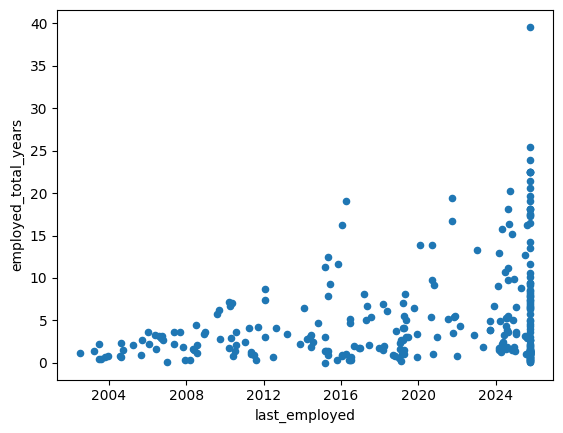

In [17]:
local_good["employed_total_years"] = local_good[("employed_total")].apply(lambda d: d.days / 365)
local_good[["last_employed", "employed_total_years"]].plot.scatter(x="last_employed", y="employed_total_years", style=".")

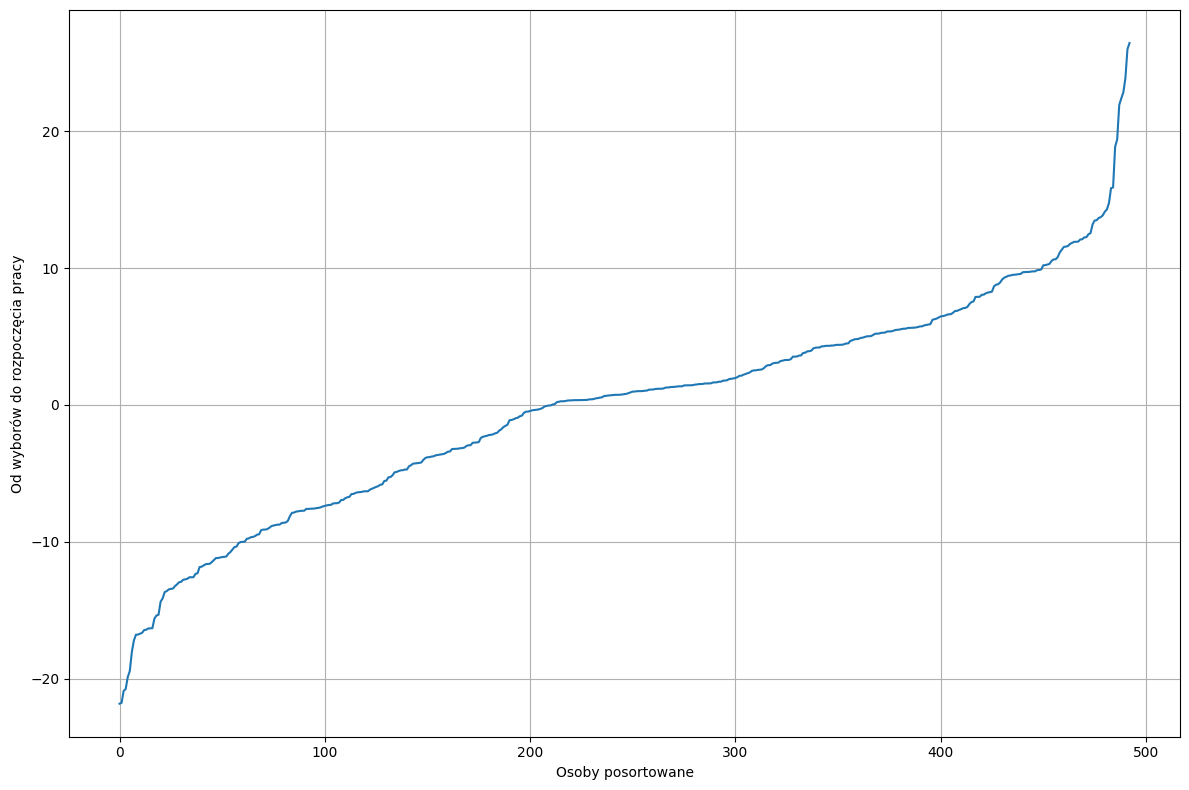

In [5]:
plt.figure(figsize=(12, 8))
ax = local_good["election_before_work"].apply(lambda duration: duration.days / 365).plot()
ax.set_xlabel("Osoby posortowane")
ax.set_ylabel("Od wyborów do rozpoczęcia pracy")
ax.grid(True)
plt.tight_layout()
plt.show()

In [6]:
d = date(year=1, month=1, day=1)
zero_delta = d - d

local_good = local_good[local_good["election_before_work"] >  zero_delta].reset_index()
display(local_good[["krs_name", "birth_date", "election_before_work", "history"]].style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

,krs_name,birth_date,election_before_work,history
0,Krzysztof Polak,1968-05-24,12 days 00:00:00,"Kandyduje w 2010 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w powiat bełchatowski Kandyduje w 2014 z list Komitet Wyborczy Wyborców ""Krzysztof Polak"" w powiat bełchatowski Kandyduje w 2018 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w powiat bełchatowski Pracuje od 2018-11-02 do 2019-02-08 w PRZEDSIĘBIORSTWO GOSPODARKI MIESZKANIOWEJ w Bełchatów Kandyduje w 2024 z list KWW PONAD PODZIAŁAMI w powiat bełchatowski"
1,Arkadiusz Tomasz Olędzki,1966-05-23,23 days 00:00:00,"Kandyduje w 2010 z list KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE w Łódź Pracuje od 2010-12-14 do 2015-03-17 w MIEJSKIE PRZEDSIĘBIORSTWO KOMUNIKACYJNE - ŁÓDŹ w Łódź Pracuje od 2011-05-24 do 2014-05-30 w MIEJSKIE PRZEDSIĘBIORSTWO GOSPODARKI KOMUNALNEJ w Zgierz Pracuje od 2015-03-14 do 2020-10-13 w PORT LOTNICZY ŁÓDŹ IM. WŁADYSŁAWA REYMONTA w Łódź Pracuje od 2017-05-13 do 2025-10-18 w WODOCIĄGI I KANALIZACJA-ZGIERZ w Zgierz Pracuje od 2021-01-20 do 2024-01-23 w ZAKŁAD WODOCIĄGÓW I KANALIZACJI ""WOD-KAN"" w Mokra Prawa Pracuje od 2024-03-17 do 2025-03-20 w FUNDUSZ ROZWOJU SPÓŁEK w Warszawa Pracuje od 2025-08-21 do 2025-10-18 w LS AIRPORT SERVICES w Warszawa"
2,Florian Wlaźlak,1949-05-04,73 days 00:00:00,Kandyduje w 1998 z list Komitet Wyborczy Akcja Wyborcza Solidarność w powiat pabianicki Kandyduje w 2002 z list KWW POROZUMIENIE SAMORZĄDOWE PRAWICY w powiat pabianicki Kandyduje w 2006 z list Komitet Wyborczy Wyborców BLOK PRAWICA RAZEM w powiat pabianicki Pracuje od 2006-03-15 do 2020-01-27 w ZAKŁAD ENERGETYKI CIEPLNEJ w Pabianice Kandyduje w 2010 z list KOMITET WYBORCZY WYBORCÓW BLOK SAMORZĄDOWY RAZEM w powiat pabianicki Kandyduje w 2014 z list Komitet Wyborczy Wyborców Blok Samorządowy Razem w powiat pabianicki Kandyduje w 2018 z list KOMITET WYBORCZY WYBORCÓW KOALICJA DLA PABIANIC GRZEGORZA MACKIEWICZA w powiat pabianicki
3,Waldemar Grzegorz Buda,1982-09-21,84 days 00:00:00,Kandyduje w 2014 z list Komitet Wyborczy Prawo i Sprawiedliwość w Łódź Pracuje od 2015-02-13 do 2016-01-25 w TOMASZOWSKIE CENTRUM ZDROWIA w Tomaszów Mazowiecki
4,Marcin Roman Majewski,1984-11-10,98 days 00:00:00,Kandyduje w 2014 z list Komitet Wyborczy Polskie Stronnictwo Ludowe w powiat sieradzki Kandyduje w 2024 z list KKW TRZECIA DROGA PSL-PL2050 SZYMONA HOŁOWNI w łódzkie Pracuje od 2024-04-08 do 2025-10-18 w ŁÓDZKA SPECJALNA STREFA EKONOMICZNA w Łódź
5,Piotr Marian Porzeżyński,1971-10-13,98 days 00:00:00,Kandyduje w 2010 z list KOMITET WYBORCZY STOWARZYSZENIA ZIEMIA BEŁCHATOWSKA w powiat bełchatowski Kandyduje w 2014 z list Komitet Wyborczy Stowarzyszenia Ziemia Bełchatowska w powiat bełchatowski Pracuje od 2015-02-27 do 2015-02-27 w BEŁCHATOWSKIE TOWARZYSTWO BUDOWNICTWA SPOŁECZNEGO w Bełchatów
6,Piotr Szcześniak,1976-06-07,102 days 00:00:00,"Kandyduje w 2006 z list Komitet Wyborczy Wyborców Sołectwa Grabina w powiat łódzki wschodni Kandyduje w 2010 z list KOMITET WYBORCZY WYBORCÓW ""NIEZALEŻNI RADNI"" w powiat łódzki wschodni Kandyduje w 2014 z list Komitet Wyborczy Wyborców Piotra Szcześniaka-Czas Na Odnowę w powiat łódzki wschodni Kandyduje w 2018 z list KOMITET WYBORCZY WYBORCÓW PIOTRA SZCZEŚNIAKA W JEDNOŚCI SIŁA w powiat łódzki wschodni Pracuje od 2019-01-31 do 2025-10-18 w ŁÓDZKI OBSZAR METROPOLITALNY w Łódź Kandyduje w 2024 z list KWW PIOTRA SZCZEŚNIAKA ZGODA BUDUJE w powiat łódzki wschodni"
7,Wiesław Stanisław Stankowski,1953-04-13,115 days 00:00:00,Kandyduje w 2010 z list KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE w powiat zgierski Pracuje od 2011-03-16 do 2014-06-17 w MIEJSKIE PRZEDSIĘBIORSTWO GOSPODARKI KOMUNALNEJ w Zgierz Kandyduje w 2014 z list Komitet Wyborczy Polskie Stronnictwo Ludowe w powiat zgierski
8,Tomasz Arkadiusz Kuśmierek,1974-01-11,121 days 00:00:00,Kandyduje w 2014 z list Komitet Wyborczy Wyborców Plus w powiat bełchatowski Pracuje od 2015-03-22 do 2016-12-30 w MIEJSKI ZAKŁAD KOMUNIKACJI w Bełchatów
9,Marek Henryk Olkiewicz,1970-01-19,122 days 00:00:00,Kand

In [7]:
# Write to output
local_output = versioned.get_path("people_lodzkie.csv")
local_good.to_csv(local_output,index=False)